In [1]:
import torch
from dataset import collate_fn, get_dataset, get_dataset_train, get_dataset_valid
from torch import nn
from torch.utils.data import DataLoader
from model import get_model, clip_loss
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
import pandas as pd

/home/eduardo/Documents/TCC/TCC-graphs-CLIP-test2/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="../data/checkpoints/clip-model",
    num_train_epochs=50,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    warmup_steps=50,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_steps=10,
    save_strategy="epoch",
    optim="adamw_torch_fused",
    bf16=True if torch.cuda.is_available() else False,
    report_to="none",
    dataloader_num_workers=6,
)


In [3]:
def compute_sims(model, ds, device="cpu"):
    model.eval()
    all_image_embs = []
    all_texts = []

    with torch.no_grad():
        for imgs, texts in ds:
            imgs = imgs.to(device).unsqueeze(0)
            all_image_embs.append(model.project_images(imgs))
            all_texts.append(texts)  # mantém lista de strings

        # concatena embeddings de todas as imagens
        image_embs = torch.cat(all_image_embs, dim=0)  # (num_images, dim)

        # codifica todos os textos
        text_embs = model.project_texts(all_texts).to(device)  # (num_texts, dim)

        # matriz de similaridade coseno
        sims = torch.matmul(image_embs, text_embs.T)  # (num_images, num_texts)

    return sims

@torch.no_grad()
def compute_silhouette(model, ds, device):
    # Calcula o índice de silhueta com base nas similaridades entre
    # as 1000 primeiras e 1000 últimas imagens comparadas com todos os textos.

    # Similaridade entre imagens e textos
    sims = compute_sims(model, ds, device)  # (num_images, num_texts)

    # Converte similaridade → distância exponencial
    dist = torch.exp(-sims.detach().cpu())

    # Normaliza [0, 1] antes do cálculo da silhueta
    dist = (dist - dist.min()) / (dist.max() - dist.min())

    # Inicializa a diagonal principal com zeros
    idx = torch.arange(dist.size(0))
    dist[idx, idx] = 0

    # cria rótulos (metade positivas, metade negativas)
    # ex: primeiros 1000 pares são positivos, últimos 1000 negativos
    n = dist.shape[0]
    half = n // 2
    labels = np.zeros(n)
    labels[:half] = 1  # primeiros = positivos

    # Calcula índice de silhueta
    score = silhouette_score(dist, labels, metric="precomputed")

    return score

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


# Configurações
device = "cuda" if torch.cuda.is_available() else "cpu"
model = get_model()
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
metrics = []

ds_train = get_dataset_train("../Graphs/watts-strogatz-train/images", "../Graphs/watts-strogatz-train/edgelists.json", split=0)
ds_valid = get_dataset_valid("../Graphs/watts-strogatz-valid/images", "../Graphs/watts-strogatz-valid/edgelists.json", split=0)

dl_train = torch.utils.data.DataLoader(ds_train,
                                 batch_size=training_args.per_device_train_batch_size,
                                 shuffle=True,
                                 num_workers=training_args.dataloader_num_workers, 
                                 collate_fn=collate_fn,)

dl_valid = torch.utils.data.DataLoader(ds_valid,
                                    batch_size=training_args.per_device_train_batch_size,
                                    shuffle=False,
                                    num_workers=training_args.dataloader_num_workers, 
                                    collate_fn=collate_fn,)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=training_args.learning_rate,
                              weight_decay=training_args.weight_decay)

model.to(device)

for epoch in range(int(training_args.num_train_epochs)):
    total_loss_train = 0
    model.train()
    for step, (imgs, texts) in enumerate(dl_train):
        imgs = imgs.to(device)

        # Tokeniza os textos do batch
        enc_texts = tokenizer(
            list(texts), padding=True, truncation=True, return_tensors="pt"
        ).to(device)

        optimizer.zero_grad()

        # logits = (batch_img, batch_text) → matriz (B, B)
        logits = model(imgs, list(texts))

        # CLIP loss (InfoNCE)
        loss = clip_loss(logits)
        loss.backward()

        # grad accumulation
        if (step + 1) % training_args.gradient_accumulation_steps == 0:
            optimizer.step()

        total_loss_train += loss.item()

    with torch.no_grad():
        total_loss_valid = 0
        model.eval()
        for step, (imgs, texts) in enumerate(dl_valid):
        
            imgs = imgs.to(device)

            # Tokeniza os textos do batch
            enc_texts = tokenizer(
                list(texts), padding=True, truncation=True, return_tensors="pt"
            ).to(device)

            # logits = (batch_img, batch_text) → matriz (B, B)
            logits = model(imgs, list(texts))

            # CLIP loss (InfoNCE)
            loss = clip_loss(logits)

            total_loss_valid += loss.item()

    # logging
    avg_loss_train = total_loss_train / len(dl_train)
    avg_loss_valid = total_loss_valid / len(dl_valid)
    #sil_score_train = compute_silhouette(model, ds_train, device=device)
    #sil_score_valid = compute_silhouette(model, ds_valid, device=device)

    #metrics.append([epoch, avg_loss_train, avg_loss_valid, sil_score_train, sil_score_valid])
    metrics.append([epoch, avg_loss_train, avg_loss_valid])


    epoch_str = f"Epoch {epoch+1}/{training_args.num_train_epochs}"

    #print("\t\tLoss Treinamento\tLoss Validacao\tSilhueta Treinamento\tSilhueta Validacao")
    print("\t\tLoss Treinamento\tLoss Validacao")

    #print(f"{epoch_str}\t{avg_loss_train:.4f}\t\t\t{avg_loss_valid:.4f}\t\t{sil_score_train:.4f}\t\t\t{sil_score_valid:.4f}")
    print(f"{epoch_str}\t{avg_loss_train:.4f}\t\t\t{avg_loss_valid:.4f}")

#df_metrics = pd.DataFrame(metrics, columns=['epoca', 'loss_train', 'loss_valid', 'sil_train', 'sil_valid'])
df_metrics = pd.DataFrame(metrics, columns=['epoca', 'loss_train', 'loss_valid'])
df_metrics.to_csv("Metricas Treinamento-Validacao-Watts-Strogatz-Dataset-Dividido-50epoch.csv")

torch.save(model.state_dict(), "Modelo-Watts-Strogatz-Dataset-Dividido-50epoch.ckpt")

Device set to use cpu


		Loss Treinamento	Loss Validacao
Epoch 1/50	2.1025			2.0900
		Loss Treinamento	Loss Validacao
Epoch 2/50	2.0830			2.0834
		Loss Treinamento	Loss Validacao
Epoch 3/50	2.0713			2.0802
		Loss Treinamento	Loss Validacao
Epoch 4/50	2.0501			2.0776
		Loss Treinamento	Loss Validacao
Epoch 5/50	2.0143			2.0749
		Loss Treinamento	Loss Validacao
Epoch 6/50	1.9534			2.0756
		Loss Treinamento	Loss Validacao
Epoch 7/50	1.8910			2.0676
		Loss Treinamento	Loss Validacao
Epoch 8/50	1.8757			2.0602
		Loss Treinamento	Loss Validacao
Epoch 9/50	1.8246			2.0418
		Loss Treinamento	Loss Validacao
Epoch 10/50	1.7943			1.9960
		Loss Treinamento	Loss Validacao
Epoch 11/50	1.7813			1.9549
		Loss Treinamento	Loss Validacao
Epoch 12/50	1.7402			1.8575
		Loss Treinamento	Loss Validacao
Epoch 13/50	1.6682			1.8079
		Loss Treinamento	Loss Validacao
Epoch 14/50	1.6420			1.7360
		Loss Treinamento	Loss Validacao
Epoch 15/50	1.5980			1.6558
		Loss Treinamento	Loss Validacao
Epoch 16/50	1.5700			1.6160
		Loss Treinament

In [ ]:
torch.save(model.state_dict(), "Modelo-Watts-Strogatz-Dataset-Dividido-50epoch.ckpt")

In [6]:
len(ds_train)

3256

In [7]:
# Calcula similaridades
sims_train = compute_sims(model, ds_train, device=device)
sims_valid = compute_sims(model, ds_valid, device=device)

In [ ]:
# Histograma comparando cada rewire com todos os outros textos - treino
sims_rewire1_train = sims_train[:56].reshape(-1)
sims_rewire2_train = sims_train[57:856].reshape(-1)
sims_rewire3_train = sims_train[857:1656].reshape(-1)
sims_rewire6_train = sims_train[1657:2456].reshape(-1)
sims_rewire10_train = sims_train[2457:3256].reshape(-1)

# Histograma comparando cada rewire com todos os outros textos - treino
sims_rewire1_valid = sims_valid[:14].reshape(-1)
sims_rewire2_valid = sims_valid[15:214].reshape(-1)
sims_rewire3_valid = sims_valid[215:414].reshape(-1)
sims_rewire6_valid = sims_valid[415:614].reshape(-1)
sims_rewire10_valid = sims_valid[615:814].reshape(-1)

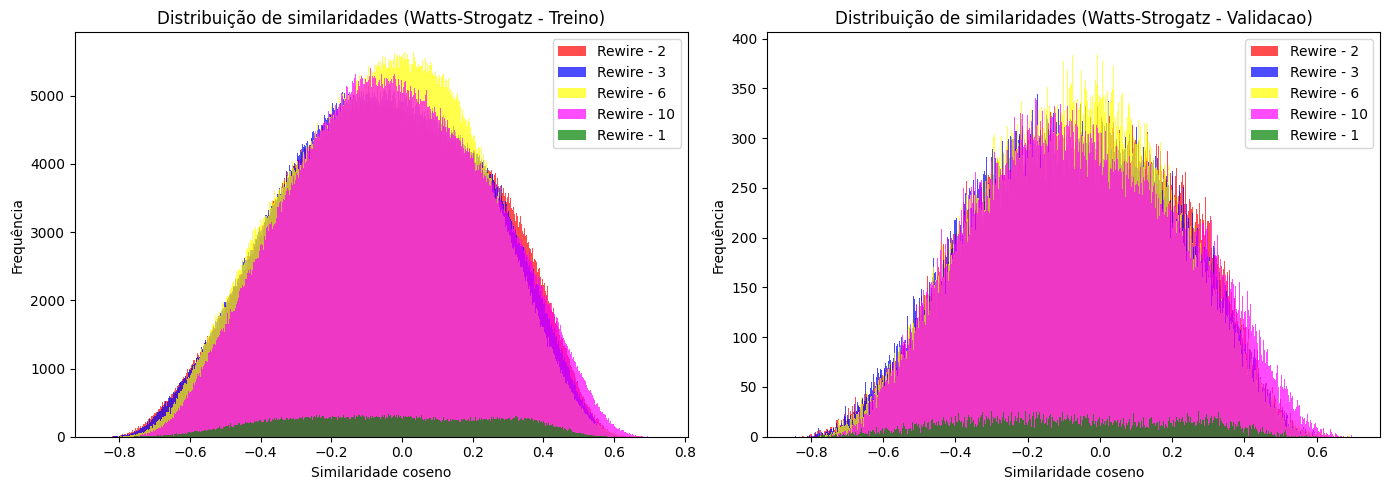

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma 1000 vs 1000
axes[0].hist(sims_rewire2_train.cpu().numpy(), bins=1000, alpha=0.7, color="red", label="Rewire - 2")
axes[0].hist(sims_rewire3_train.cpu().numpy(), bins=1000, alpha=0.7, color="blue", label="Rewire - 3")
axes[0].hist(sims_rewire6_train.cpu().numpy(), bins=1000, alpha=0.7, color="yellow", label="Rewire - 6")
axes[0].hist(sims_rewire10_train.cpu().numpy(), bins=1000, alpha=0.7, color="magenta", label="Rewire - 10")
axes[0].hist(sims_rewire1_train.cpu().numpy(), bins=1000, alpha=0.7, color="green", label="Rewire - 1")

axes[0].set_title("Distribuição de similaridades (Watts-Strogatz - Treino)")
axes[0].set_xlabel("Similaridade coseno")
axes[0].set_ylabel("Frequência")
axes[0].legend()

# Histograma 250 vs 250
axes[1].hist(sims_rewire2_valid.cpu().numpy(), bins=1000, alpha=0.7, color="red", label="Rewire - 2")
axes[1].hist(sims_rewire3_valid.cpu().numpy(), bins=1000, alpha=0.7, color="blue", label="Rewire - 3")
axes[1].hist(sims_rewire6_valid.cpu().numpy(), bins=1000, alpha=0.7, color="yellow", label="Rewire - 6")
axes[1].hist(sims_rewire10_valid.cpu().numpy(), bins=1000, alpha=0.7, color="magenta", label="Rewire - 10")
axes[1].hist(sims_rewire1_valid.cpu().numpy(), bins=1000, alpha=0.7, color="green", label="Rewire - 1")

axes[1].set_title("Distribuição de similaridades (Watts-Strogatz - Validacao)")
axes[1].set_xlabel("Similaridade coseno")
axes[1].set_ylabel("Frequência")
axes[1].legend()

plt.tight_layout()
plt.show()

In [24]:
sims_train.shape

torch.Size([3256, 3256])

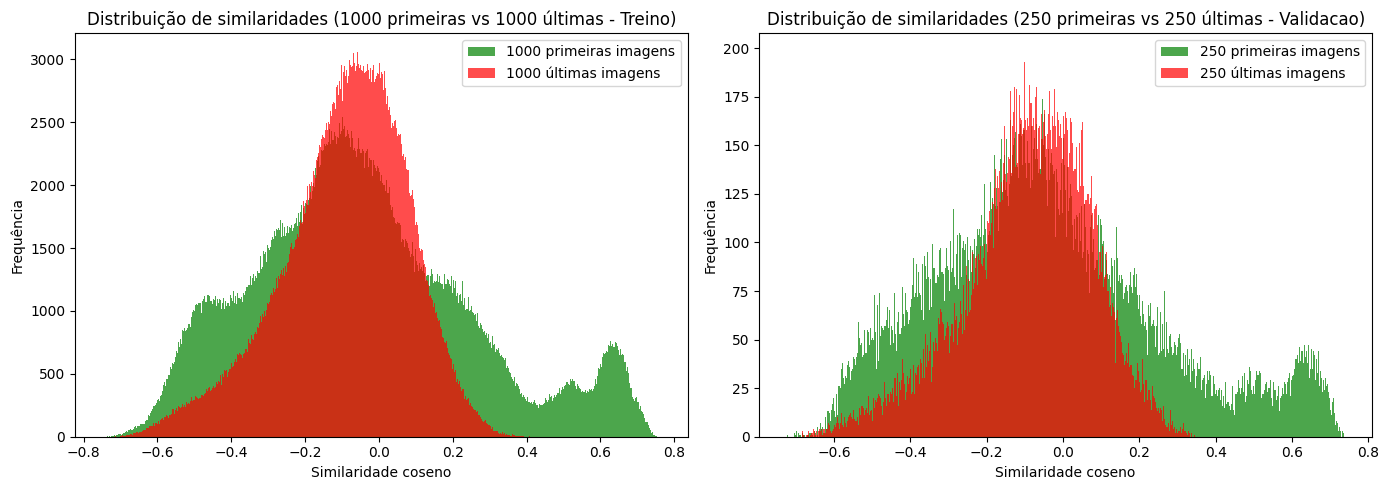

In [10]:
# Quadrante superior esquerdo x Quadrante superior direito
# [:x, :x] = Q1
# [:x, x:] = Q2
# [x:, :x] = Q3
# [x:, x:] = Q4
sims_first1000 = sims_train[:1000, :1000].reshape(-1)
sims_last1000 = sims_train[:1000, 1000:].reshape(-1)

sims_first250 = sims_valid[:250, :250].reshape(-1)
sims_last250 = sims_valid[:250, 250:].reshape(-1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma 1000 vs 1000
axes[0].hist(sims_first1000.cpu().numpy(), bins=1000, alpha=0.7, color="green", label="1000 primeiras imagens")
axes[0].hist(sims_last1000.cpu().numpy(), bins=1000, alpha=0.7, color="red", label="1000 últimas imagens")
axes[0].set_title("Distribuição de similaridades (1000 primeiras vs 1000 últimas - Treino)")
axes[0].set_xlabel("Similaridade coseno")
axes[0].set_ylabel("Frequência")
axes[0].legend()

# Histograma 250 vs 250
axes[1].hist(sims_first250.cpu().numpy(), bins=1000, alpha=0.7, color="green", label="250 primeiras imagens")
axes[1].hist(sims_last250.cpu().numpy(), bins=1000, alpha=0.7, color="red", label="250 últimas imagens")
axes[1].set_title("Distribuição de similaridades (250 primeiras vs 250 últimas - Validacao)")
axes[1].set_xlabel("Similaridade coseno")
axes[1].set_ylabel("Frequência")
axes[1].legend()

plt.tight_layout()
plt.show()

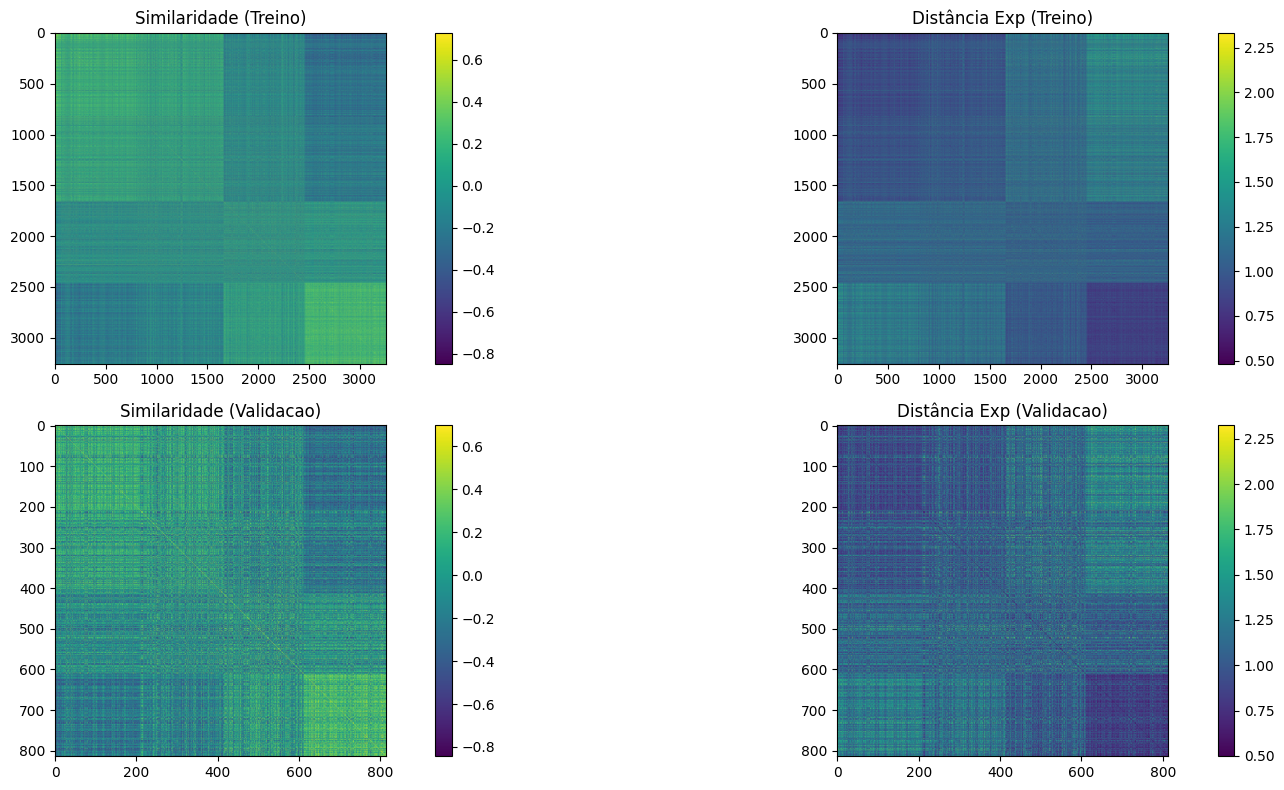

In [25]:
sims_train_matrix = sims_train.detach().cpu()
dist_train_matrix = torch.exp(-sims_train).detach().cpu()

sims_valid_matrix = sims_valid.detach().cpu()
dist_valid_matrix = torch.exp(-sims_valid).detach().cpu()

fig, axes = plt.subplots(2, 2, figsize=(18, 8))  # 2 linhas, 2 colunas
axes = axes.flatten()

# Plot da similaridade
im0 = axes[0].imshow(sims_train_matrix, cmap='viridis')
axes[0].set_title("Similaridade (Treino)")
fig.colorbar(im0, ax=axes[0])

# Plot da distância exponencial
im1 = axes[1].imshow(dist_train_matrix, cmap='viridis')
axes[1].set_title("Distância Exp (Treino)")
fig.colorbar(im1, ax=axes[1])

# Plot da similaridade
im2 = axes[2].imshow(sims_valid_matrix, cmap='viridis')
axes[2].set_title("Similaridade (Validacao)")
fig.colorbar(im2, ax=axes[2])

# Plot da distância exponencial
im3 = axes[3].imshow(dist_valid_matrix, cmap='viridis')
axes[3].set_title("Distância Exp (Validacao)")
fig.colorbar(im3, ax=axes[3])

plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import top_k_accuracy_score

top = 5
top_k_train = top_k_accuracy_score(range(len(sims_train)), sims_train.cpu(), k=top)
top_k_valid = top_k_accuracy_score(range(len(sims_valid)), sims_valid.cpu(), k=top)

print(f"top{top} treino = {top_k_train}\ntop{top} validacao = {top_k_valid}")

top5 treino = 0.2628992628992629
top5 validacao = 0.6130221130221131


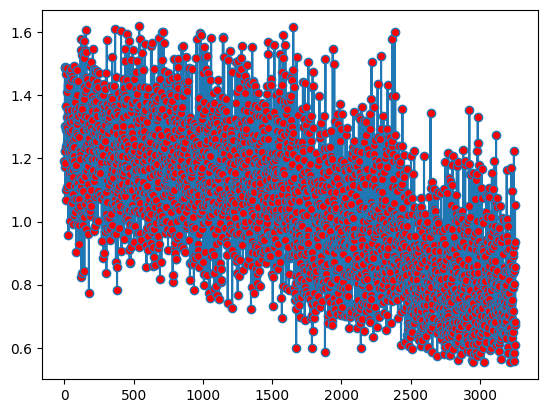

In [38]:
idx_ref = 3000
sims_img = sims_train[idx_ref]
plt.plot(torch.exp(-sims_img.cpu()), "-o", markerfacecolor="red")


In [61]:
[ds_train[idx][1] for idx in range(1990, 2000)]

['0-1 0-6 0-9 1-6 2-4 2-5 2-7 3-9 5-6 8-9',
 '0-3 1-2 2-3 2-7 2-9 3-7 3-8 4-9 5-6 6-7',
 '0-1 0-6 0-9 1-8 2-3 3-6 4-6 4-7 5-8 8-9',
 '0-3 0-9 1-5 2-3 3-4 3-8 4-5 4-6 5-7 5-9',
 '0-1 1-5 1-7 2-4 2-8 3-4 3-9 6-7 7-9 8-9',
 '0-8 0-9 1-6 1-9 2-3 2-7 3-6 4-5 5-7 8-9',
 '0-1 0-5 0-7 1-2 1-6 1-8 2-5 3-4 3-9 4-5',
 '0-1 0-3 0-7 0-9 1-5 2-4 2-5 4-5 4-6 8-9',
 '0-1 0-3 0-9 1-6 1-7 2-9 4-5 4-7 5-8 8-9',
 '0-6 1-4 1-7 2-3 3-8 5-7 6-7 6-9 7-8 8-9']

In [62]:
def sim_img_alltext(model, image, ds, device="cpu"):
    model.eval()
    all_texts = []

    with torch.no_grad():
        for _, texts in ds:
            all_texts.append(texts)  # mantém lista de strings

        img_emb = model.project_images(image.unsqueeze(0).to(device))

        # codifica todos os textos
        text_embs = model.project_texts(all_texts).to(device)  # (num_texts, dim)

        # matriz de similaridade coseno
        sims = torch.matmul(img_emb, text_embs.T)  # (num_images, num_texts)

    return sims

In [63]:
ds = get_dataset_train("../Graphs/watts-strogatz-train/images", "../Graphs/watts-strogatz-train/edgelists.json", split=0)
ds.ds.ids

['1_rewires_0001',
 '1_rewires_0002',
 '1_rewires_0003',
 '1_rewires_0004',
 '1_rewires_0006',
 '1_rewires_0007',
 '1_rewires_0008',
 '1_rewires_0009',
 '1_rewires_0011',
 '1_rewires_0012',
 '1_rewires_0013',
 '1_rewires_0014',
 '1_rewires_0016',
 '1_rewires_0017',
 '1_rewires_0018',
 '1_rewires_0019',
 '1_rewires_0021',
 '1_rewires_0022',
 '1_rewires_0023',
 '1_rewires_0024',
 '1_rewires_0026',
 '1_rewires_0027',
 '1_rewires_0028',
 '1_rewires_0029',
 '1_rewires_0031',
 '1_rewires_0032',
 '1_rewires_0033',
 '1_rewires_0034',
 '1_rewires_0036',
 '1_rewires_0037',
 '1_rewires_0038',
 '1_rewires_0039',
 '1_rewires_0041',
 '1_rewires_0042',
 '1_rewires_0043',
 '1_rewires_0044',
 '1_rewires_0046',
 '1_rewires_0047',
 '1_rewires_0048',
 '1_rewires_0049',
 '1_rewires_0051',
 '1_rewires_0052',
 '1_rewires_0053',
 '1_rewires_0054',
 '1_rewires_0056',
 '1_rewires_0057',
 '1_rewires_0058',
 '1_rewires_0059',
 '1_rewires_0061',
 '1_rewires_0062',
 '1_rewires_0063',
 '1_rewires_0064',
 '1_rewires_

In [64]:
len(ds)

3256

/tmp/ipykernel_14272/610776573.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


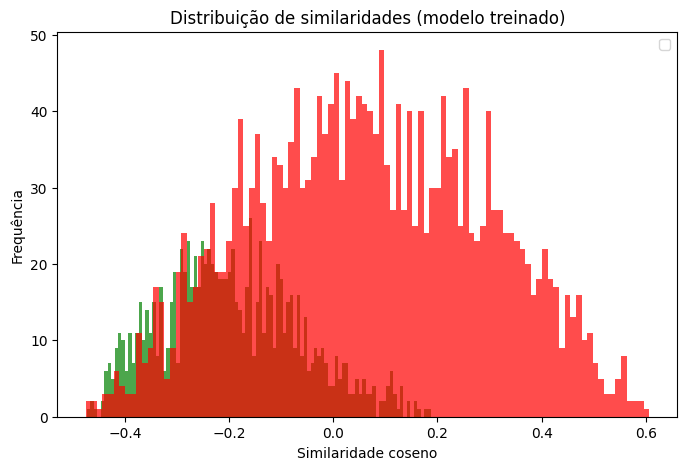

In [65]:
image, _ = ds[idx_ref]
sims2 = sim_img_alltext(model, image, ds, device=device)

sims_first1000 = sims2[0,:1000].reshape(-1)
sims_last1000 = sims2[0,1000:].reshape(-1)

plt.figure(figsize=(8,5))
plt.hist(sims_first1000.cpu().numpy(), bins=100, alpha=0.7, color="green")
plt.hist(sims_last1000.cpu().numpy(), bins=100, alpha=0.7, color="red")


plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")
plt.title("Distribuição de similaridades (modelo treinado)")
plt.legend()
plt.show()

In [66]:
sims2.shape

torch.Size([1, 3256])

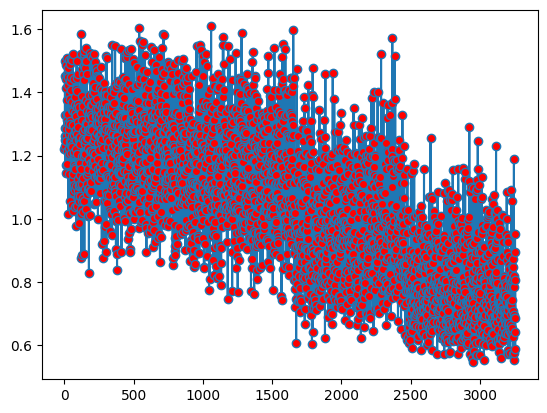

In [67]:
plt.plot(torch.exp(-sims2[0].cpu()), "-o", markerfacecolor="red")

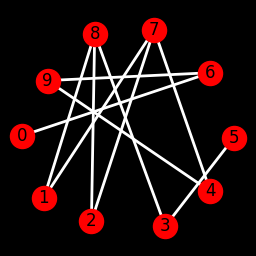

'0-6 1-7 1-8 2-7 2-8 3-5 3-8 4-7 4-9 6-9'

In [68]:
ds.transform = None
display(*ds[idx_ref])

'------rewire 1 menos similares--------'

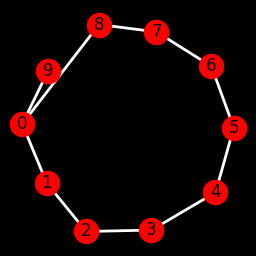

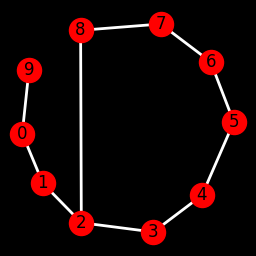

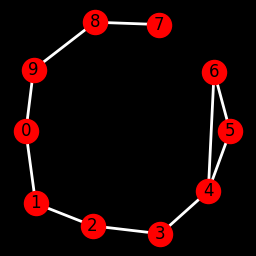

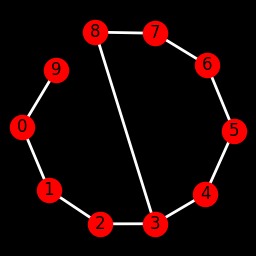

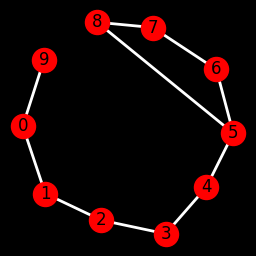

'------rewire 1 mais similares--------'

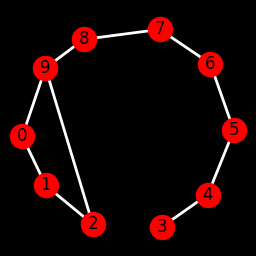

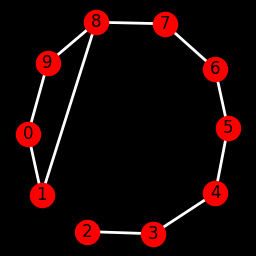

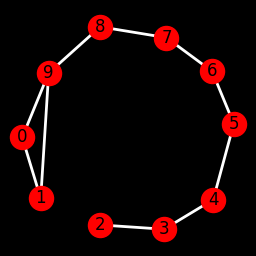

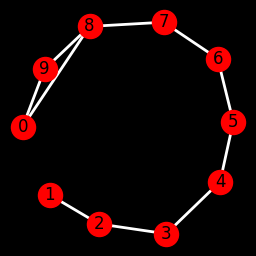

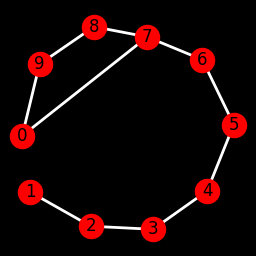

'------rewire 2 menos similares--------'

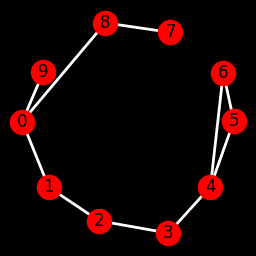

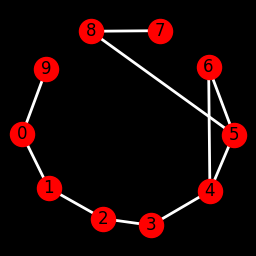

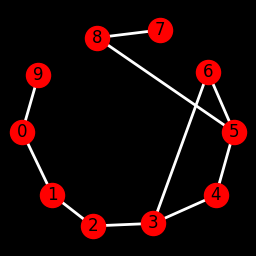

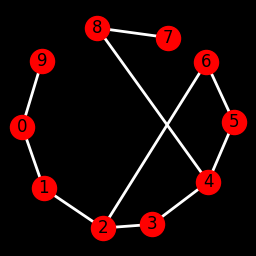

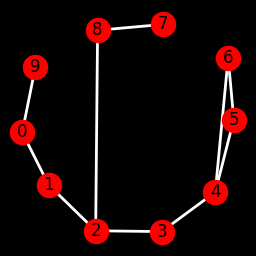

'------rewire 2 mais similares--------'

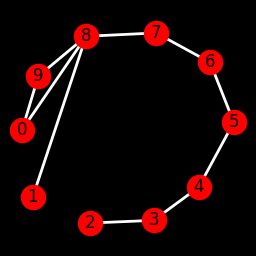

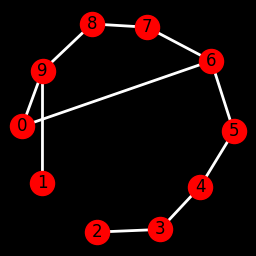

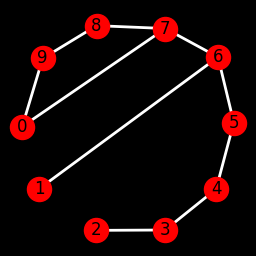

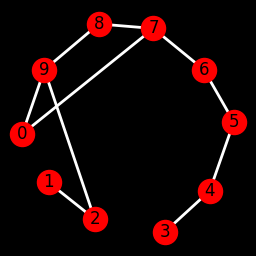

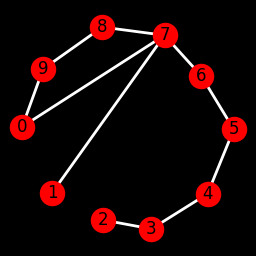

'------rewire 3 menos similares--------'

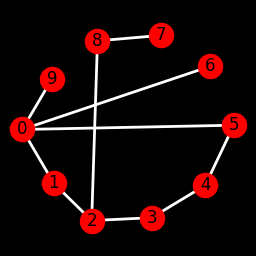

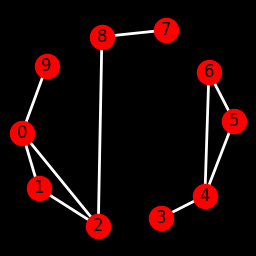

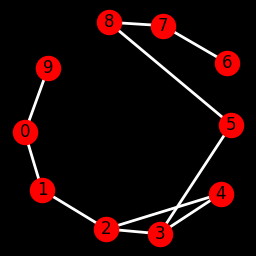

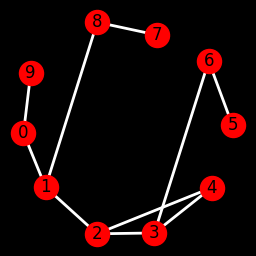

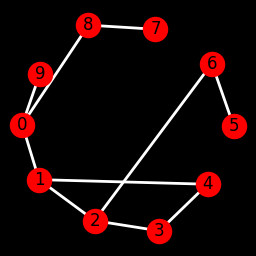

'------rewire 3 mais similares--------'

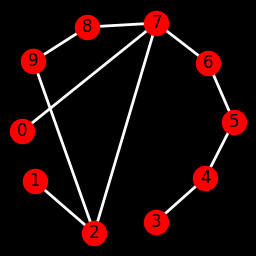

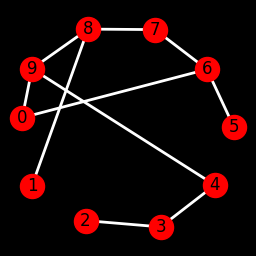

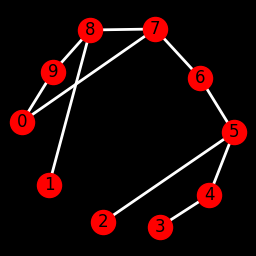

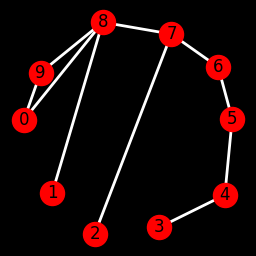

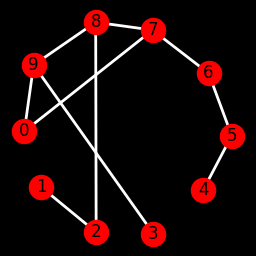

'------rewire 6 menos similares--------'

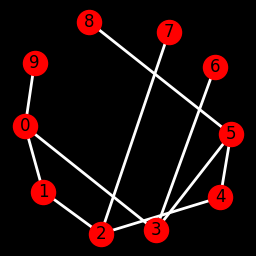

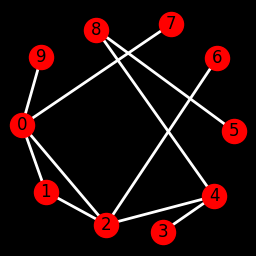

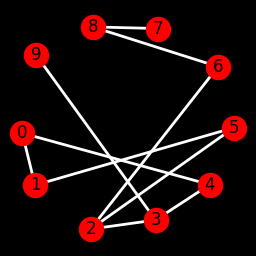

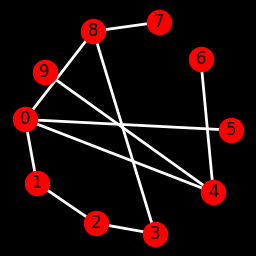

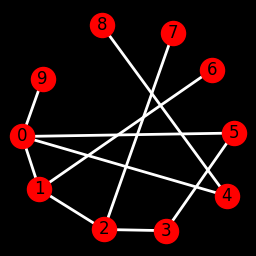

'------rewire 6 mais similares--------'

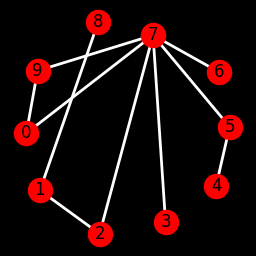

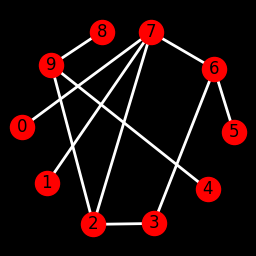

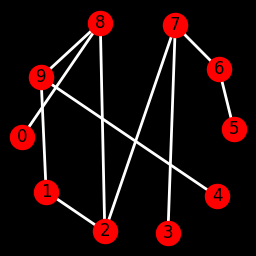

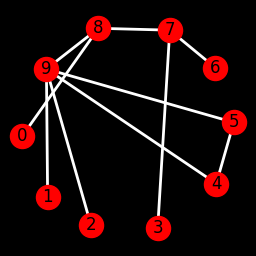

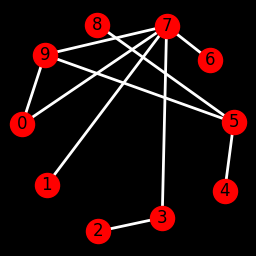

'------rewire 10 menos similares--------'

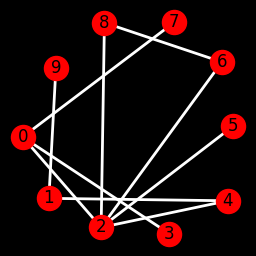

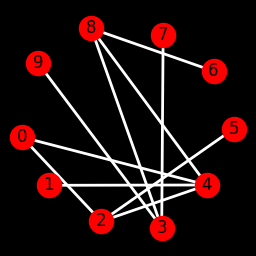

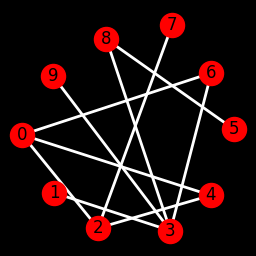

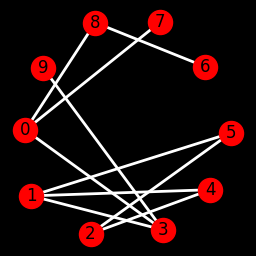

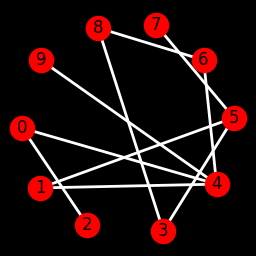

'------rewire 10 mais similares--------'

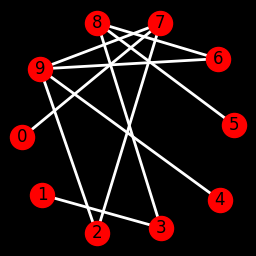

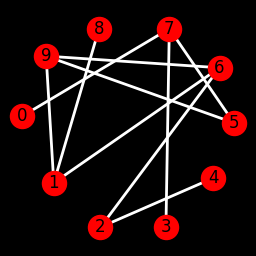

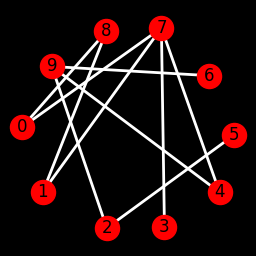

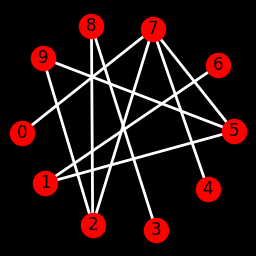

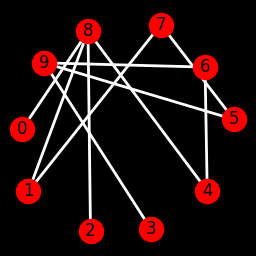

In [76]:
def organize(idx_ref, sims, ds, columns):

    sims_img = sims[idx_ref, columns]
    idx_ord = torch.argsort(sims_img)
    #sims_img_ord = sims_img[idx_ord]
    ds_ord = [ds[columns.start+idx][0] for idx in idx_ord]

    return ds_ord

ds_rewire1_ord = organize(idx_ref, sims_train, ds, slice(0, 56))
ds_rewire2_ord = organize(idx_ref, sims_train, ds, slice(57, 856))
ds_rewire3_ord = organize(idx_ref, sims_train, ds, slice(857, 1656))
ds_rewire6_ord = organize(idx_ref, sims_train, ds, slice(1657, 2456))
ds_rewire10_ord = organize(idx_ref, sims_train, ds, slice(2457, 3256))

display("------rewire 1 menos similares--------", *ds_rewire1_ord[:5])
display("------rewire 1 mais similares--------", *ds_rewire1_ord[-5:])
display( "------rewire 2 menos similares--------", *ds_rewire2_ord[:5])
display("------rewire 2 mais similares--------", *ds_rewire2_ord[-5:])
display("------rewire 3 menos similares--------", *ds_rewire3_ord[:5])
display("------rewire 3 mais similares--------", *ds_rewire3_ord[-5:])
display( "------rewire 6 menos similares--------", *ds_rewire6_ord[:5])
display("------rewire 6 mais similares--------", *ds_rewire6_ord[-5:])
display("------rewire 10 menos similares--------", *ds_rewire10_ord[:5])
display("------rewire 10 mais similares--------", *ds_rewire10_ord[-5:])